In [1]:
import os
import xarray as xr 
import numpy as np
from statistics import NormalDist
import statsmodels.api as smapi
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy
import cartopy.crs as ccrs
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
sns.set(style='ticks',font_scale=2)

In [2]:
root_dir = '/dartfs-hpc/rc/lab/C/CMIG'
project_dir = os.path.join(root_dir,'agottlieb','snow_nonlinearity')
data_dir = os.path.join(project_dir,'data','processed')

In [3]:
def ols_trend(x,y,deg=1):
    if np.isnan(x).all() or np.isnan(y).all():
        return np.nan
    if len(x)==0 or len(y)==0:
        return np.nan
    isna = np.logical_or(np.isnan(x),np.isnan(y))
    x = x[~isna]
    y = y[~isna]
    if len(x)<10 or len(y)<10:
        return np.nan
    if (y==y.max()).all():
        return 0
    try:
        return np.polyfit(x,y,deg=deg)[0]
    except:
        return np.nan


In [4]:
snotel_ds = xr.open_dataset(os.path.join(data_dir,'snotel','ndjfm_stats.nc')).sel(time=slice("1998","2022"))
ecad_ds = xr.open_dataset(os.path.join(data_dir,'ecad','ndjfm_stats.nc')).sel(time=slice("1998","2022"))
ghcnd_ds = xr.open_dataset(os.path.join(data_dir,'ghcnd','ndjfm_stats.nc')).sel(time=slice("1998","2022"))
insitu_ds = xr.concat([snotel_ds,ecad_ds,ghcnd_ds],dim='site')
insitu_ds = insitu_ds.where(insitu_ds['wy_sc'].median("time")>30,drop=True)
insitu_ds = insitu_ds.where((insitu_ds['wy_sc'].count("time")>=20)&(insitu_ds['tavg'].count("time")>=20),drop=True)
insitu_ds['cold_frac']=1-insitu_ds['warm_days_tavg']/151
insitu_ds['wy_sc'] = insitu_ds['wy_sc'].clip(max=365)
insitu_ds['sc_frac'] = insitu_ds['wy_sc']/365
insitu_ds['snow_frac'] = insitu_ds['snow'].sum("time")/(insitu_ds['rain'].sum('time')+insitu_ds['snow'].sum("time"))
insitu_ds['melt_frac'] = 1-insitu_ds['total_melt_prepeak'].sum("time")/insitu_ds['total_melt'].sum("time")
insitu_ds['swe_pct'] = 100*insitu_ds['peak_swe']/insitu_ds['peak_swe'].median("time")
insitu_ds['tavg_anom'] = insitu_ds['tavg']-insitu_ds['tavg'].mean("time")
insitu_ds['tavg_clim'] = insitu_ds['tavg'].mean("time")
insitu_ds['std_clim'] = insitu_ds['tavg_std'].mean("time")

In [7]:
insitu_df = insitu_ds[['swe_pct','tavg_anom','tavg_clim','std_clim',]].to_dataframe().dropna()
insitu_df['tanom_bin'] = pd.cut(insitu_df['tavg_anom'],bins=np.arange(-3.5,3.6,1),labels=np.arange(-3,4))
insitu_df['sd30'] = insitu_df['swe_pct']<30
insitu_df['sd50'] = insitu_df['swe_pct']<50
insitu_df['sd70'] = insitu_df['swe_pct']<70

In [9]:
sd50_lr = []
sd30_lr = []
sd70_lr = []
for t in np.arange(-40,6):
    _df = insitu_df[(insitu_df['tavg_clim']>t-2.5)&(insitu_df['tavg_clim']<=t+2.5)]
    lr30 = LogisticRegression().fit(_df[['tavg_anom']],_df['sd30'])
    lr50 = LogisticRegression().fit(_df[['tavg_anom']],_df['sd50'])
    lr70 = LogisticRegression().fit(_df[['tavg_anom']],_df['sd70'])
    sd30_lr.append(lr30.predict_proba(np.linspace(-5,5,101).reshape(-1,1))[:,[1]])
    sd50_lr.append(lr50.predict_proba(np.linspace(-5,5,101).reshape(-1,1))[:,[1]])
    sd70_lr.append(lr70.predict_proba(np.linspace(-5,5,101).reshape(-1,1))[:,[1]])

sd30_lr = np.concatenate(sd30_lr,axis=1)
sd30_lr_df = pd.DataFrame(sd30_lr,index=np.linspace(-5,5,101),columns=np.arange(-40,6))

sd50_lr = np.concatenate(sd50_lr,axis=1)
sd50_lr_df = pd.DataFrame(sd50_lr,index=np.linspace(-5,5,101),columns=np.arange(-40,6))

sd70_lr = np.concatenate(sd70_lr,axis=1)
sd70_lr_df = pd.DataFrame(sd70_lr,index=np.linspace(-5,5,101),columns=np.arange(-40,6))


In [10]:
swe_comp = []
counts = []
for t in np.arange(-20,6):
    if t==-20:
        _df = insitu_df[insitu_df['tavg_clim']<t-2.5]
    else:
        _df = insitu_df[(insitu_df['tavg_clim']>t-2.5)&(insitu_df['tavg_clim']<=t+2.5)]
    swe_comp.append(_df.groupby("tanom_bin").agg({"swe_pct":"median"}))
    counts.append(_df.groupby("tanom_bin").agg({"swe_pct":"count"}))
swe_comp = pd.concat(swe_comp,axis=1)
swe_comp.columns=np.arange(-20,6)

counts = pd.concat(counts,axis=1)
counts.columns=np.arange(-20,6)

swe_comp = swe_comp[counts>=10]

In [12]:
sd30_comp = []
counts = []
for t in np.arange(-20,6):
    if t==-20:
        _df = insitu_df[insitu_df['tavg_clim']<t-2.5]
    else:
        _df = insitu_df[(insitu_df['tavg_clim']>t-2.5)&(insitu_df['tavg_clim']<=t+2.5)]
    sd30_comp.append(_df.groupby("tanom_bin").agg({"sd30":"mean"}))
    counts.append(_df.groupby("tanom_bin").agg({"sd30":"count"}))
sd30_comp = pd.concat(sd30_comp,axis=1)
sd30_comp.columns=np.arange(-20,6)

counts = pd.concat(counts,axis=1)
counts.columns=np.arange(-20,6)

sd30_comp = sd30_comp[counts>=10]

In [13]:
sd50_comp = []
counts = []
for t in np.arange(-20,6):
    if t==-20:
        _df = insitu_df[insitu_df['tavg_clim']<t-2.5]
    else:
        _df = insitu_df[(insitu_df['tavg_clim']>t-2.5)&(insitu_df['tavg_clim']<=t+2.5)]
    sd50_comp.append(_df.groupby("tanom_bin").agg({"sd50":"mean"}))
    counts.append(_df.groupby("tanom_bin").agg({"sd50":"count"}))
sd50_comp = pd.concat(sd50_comp,axis=1)
sd50_comp.columns=np.arange(-20,6)

counts = pd.concat(counts,axis=1)
counts.columns=np.arange(-20,6)

sd50_comp = sd50_comp[counts>=10]

In [14]:
sd70_comp = []
counts = []
for t in np.arange(-20,6):
    if t==-20:
        _df = insitu_df[insitu_df['tavg_clim']<t-2.5]
    else:
        _df = insitu_df[(insitu_df['tavg_clim']>t-2.5)&(insitu_df['tavg_clim']<=t+2.5)]
    sd70_comp.append(_df.groupby("tanom_bin").agg({"sd70":"mean"}))
    counts.append(_df.groupby("tanom_bin").agg({"sd70":"count"}))
sd70_comp = pd.concat(sd70_comp,axis=1)
sd70_comp.columns=np.arange(-20,6)

counts = pd.concat(counts,axis=1)
counts.columns=np.arange(-20,6)

sd70_comp = sd70_comp[counts>=10]

In [15]:
ims_ds = xr.open_dataset(os.path.join(data_dir,'ims_24km','wy_sc.nc')).sel(time=slice("1998","2022"))
era5_ds = xr.open_dataset(os.path.join(data_dir,'era5','ndjfm_stats.nc')).sel(time=slice("1998","2022"))
ims_ds['sc'] = ims_ds['sc'].clip(max=365)

sc_mask = (ims_ds['sc'].median("time")>30)&(ims_ds['sc'].median("time")<364) # keep placs with snow cover in >3/4 years
ims_ds = ims_ds.where(sc_mask)
era5_ds = era5_ds.where(sc_mask)
era5_ds['tavg_clim'] = era5_ds['tavg'].mean("time")


In [17]:
def get_sd_risk(tclim,wl=1,sdlev=50):
    if np.isnan(tclim):
        return np.nan
    else:
        if sdlev==30:
            return sd30_lr_df[min(np.round(tclim),5)].loc[wl]-sd30_lr_df[min(np.round(tclim),5)].loc[0]
        elif sdlev==50:
            return sd50_lr_df[min(np.round(tclim),5)].loc[wl]-sd50_lr_df[min(np.round(tclim),5)].loc[0]
        elif sdlev==70:
            return sd70_lr_df[min(np.round(tclim),5)].loc[wl]-sd70_lr_df[min(np.round(tclim),5)].loc[0]


sd30_risk_plus1 = xr.apply_ufunc(get_sd_risk,
                               era5_ds['tavg_clim'],
                               input_core_dims=[[]],
                                kwargs=dict(wl=1,sdlev=30),
                               vectorize=True)

sd30_risk_plus2 = xr.apply_ufunc(get_sd_risk,
                               era5_ds['tavg_clim'],
                               input_core_dims=[[]],
                               kwargs=dict(wl=2,sdlev=30),
                               vectorize=True)



sd50_risk_plus1 = xr.apply_ufunc(get_sd_risk,
                               era5_ds['tavg_clim'],
                               input_core_dims=[[]],
                                kwargs=dict(wl=1,sdlev=50),
                               vectorize=True)

sd50_risk_plus2 = xr.apply_ufunc(get_sd_risk,
                               era5_ds['tavg_clim'],
                               input_core_dims=[[]],
                               kwargs=dict(wl=2,sdlev=50),
                               vectorize=True)

sd70_risk_plus1 = xr.apply_ufunc(get_sd_risk,
                               era5_ds['tavg_clim'],
                               input_core_dims=[[]],
                                kwargs=dict(wl=1,sdlev=70),
                               vectorize=True)

sd70_risk_plus2 = xr.apply_ufunc(get_sd_risk,
                               era5_ds['tavg_clim'],
                               input_core_dims=[[]],
                               kwargs=dict(wl=2,sdlev=70),
                               vectorize=True)


In [18]:
t_cols = sns.color_palette("YlGnBu_r",len(np.arange(-20,6))+1)
t_cmap = mpl.colors.ListedColormap(t_cols[1:-1])
t_cmap.set_under(t_cols[0])
t_cmap.set_over(t_cols[-1])
t_norm = plt.Normalize(vmin=-20,vmax=5)

In [19]:
sd_cols = sns.color_palette("YlOrRd",len(np.arange(0,0.41,0.05)))
sd_cmap = mpl.colors.ListedColormap(sd_cols[:-1])
sd_cmap.set_over(sd_cols[-1])
sd_norm = plt.Normalize(vmin=0,vmax=0.4)

In [45]:
hl_cols = [-8,-4,0,4]

In [46]:
import matplotlib.patheffects as pe


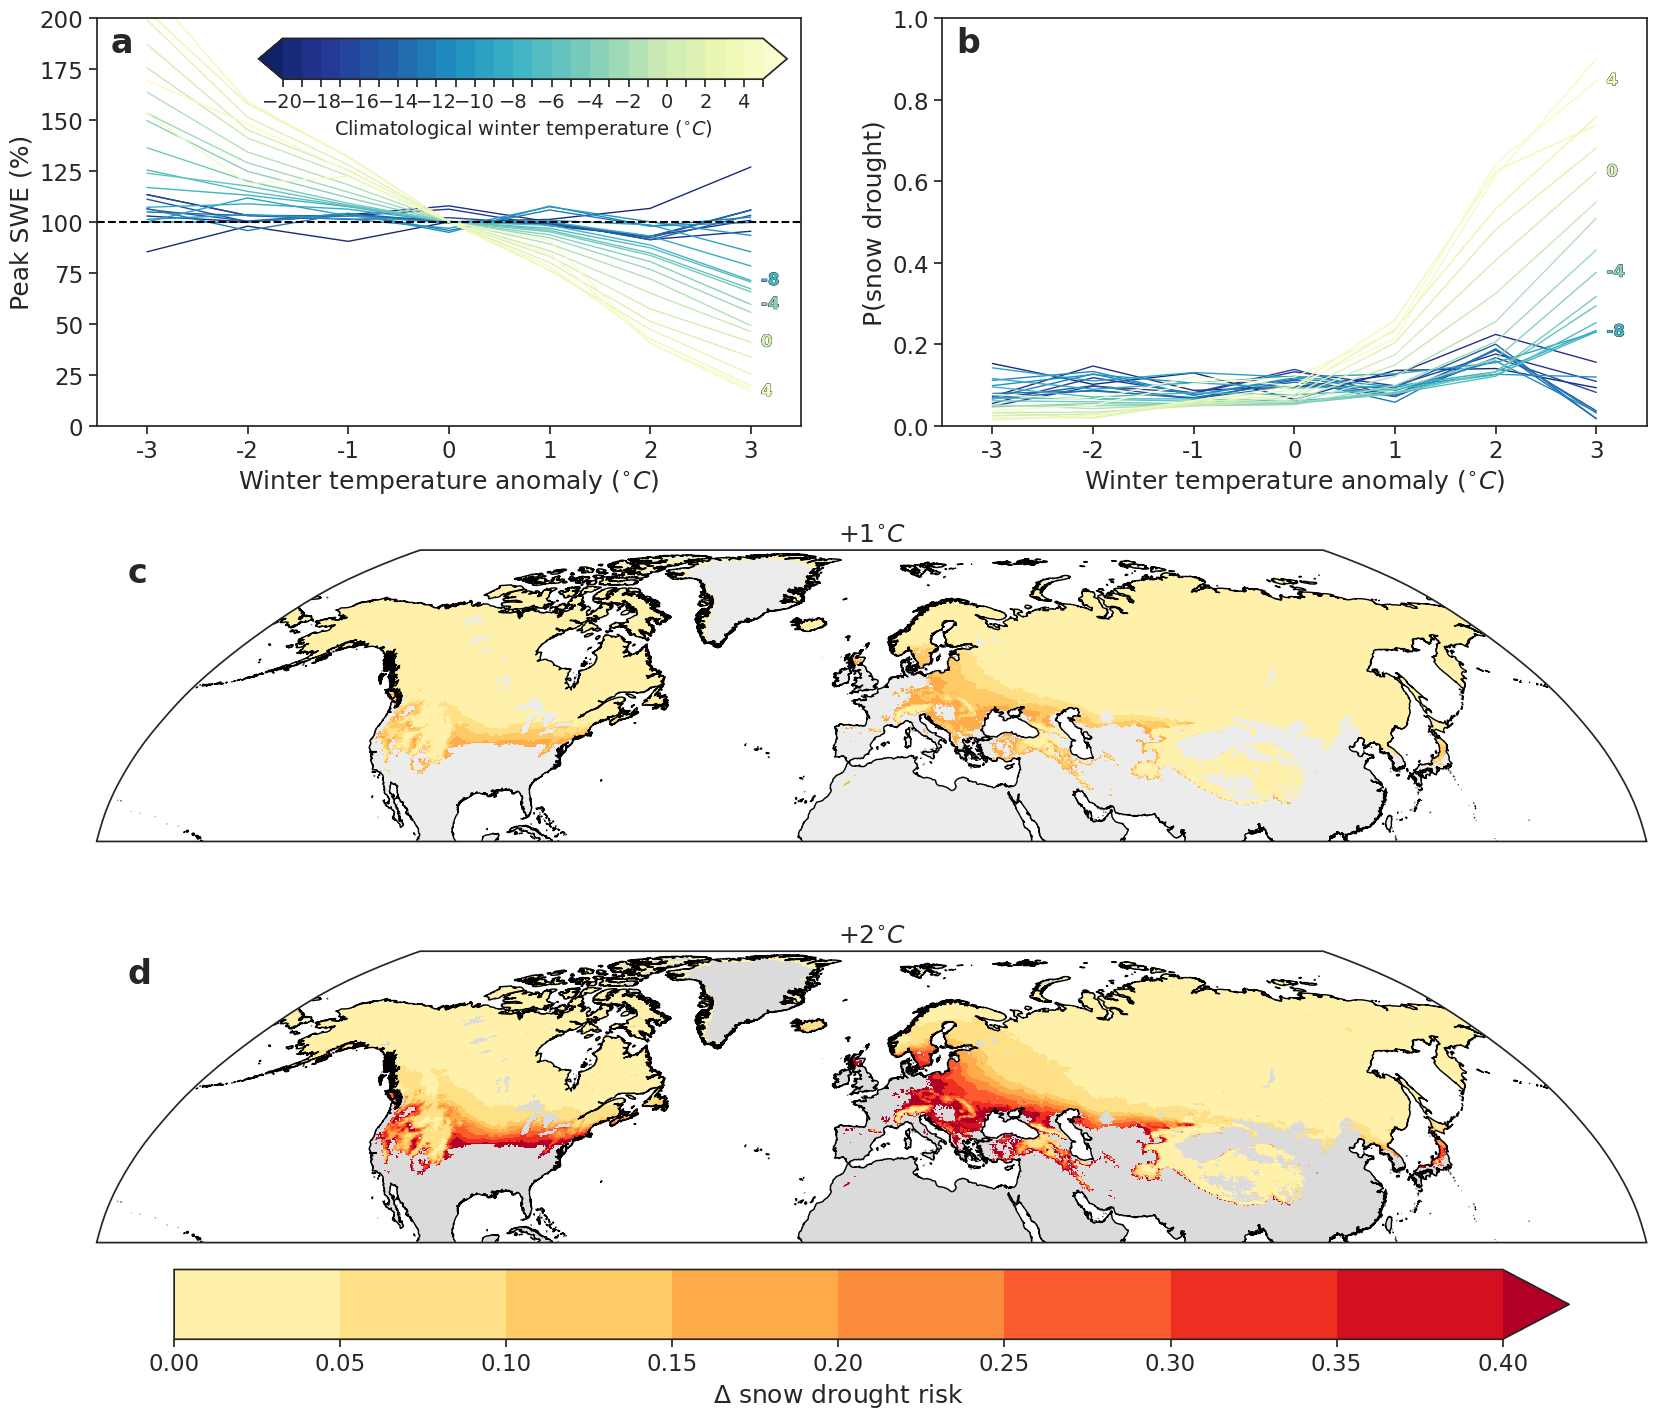

In [53]:
fig=plt.figure(figsize=(20,18))
gs = gridspec.GridSpec(nrows=3,ncols=2,width_ratios=[1,1],figure=fig)
ax1 = plt.subplot(gs[0,0])
swe_comp.plot(ax=ax1,cmap=t_cmap,lw=1,legend=False)
# swe_comp[hl_cols].plot(ax=ax1,cmap=t_cmap,lw=7,legend=False)
ax1.axhline(100,color='black',linestyle='--')
ax1.set_ylim(0,200)
ax1.set_xlabel("Winter temperature anomaly ($^{\circ}C$)")
ax1.set_ylabel("Peak SWE (%)")
ax1.text(0.02,0.98,'a',ha='left',va='top',fontweight='bold',fontsize=24,transform=ax1.transAxes)
for t in hl_cols:
    ax1.text(6.1,swe_comp.loc[3][t],f'{t}',ha='left',va='center',fontsize=12,color=t_cmap(t_norm(t)),fontweight='bold',path_effects=[pe.withStroke(linewidth=0.5,foreground='black')])
ax1.set_xlim(-0.5,6.5)
ax2 = plt.subplot(gs[0,1])
sd50_comp.plot(ax=ax2,cmap=t_cmap,lw=1,legend=False)
for t in hl_cols:
    ax2.text(6.1,sd50_comp.loc[3][t],f'{t}',ha='left',va='center',fontsize=12,color=t_cmap(t_norm(t)),fontweight='bold',path_effects=[pe.withStroke(linewidth=0.5,foreground='black')])
ax2.set_xlim(-0.5,6.5)
ax2.set_ylim(0,1)
ax2.set_xlabel("Winter temperature anomaly ($^{\circ}C$)")
ax2.set_ylabel("P(snow drought)")
ax2.text(0.02,0.98,'b',ha='left',va='top',fontweight='bold',fontsize=24,transform=ax2.transAxes)

ax3 = plt.subplot(gs[1,:],projection=ccrs.Robinson())
sd50_risk_plus1.plot(ax=ax3,transform=ccrs.PlateCarree(),cmap=sd_cmap,norm=sd_norm,add_colorbar=False)
ax3.coastlines('10m')
ax3.add_feature(cartopy.feature.LAND,color='grey',alpha=0.15)
ax3.set_extent([-180,180,20,85],ccrs.PlateCarree())
ax3.text(0.02,0.98,'c',ha='left',va='top',fontweight='bold',fontsize=24,transform=ax3.transAxes)
ax3.title.set_text("+1$^{\circ}C$")

ax4 = plt.subplot(gs[2,:],projection=ccrs.Robinson())
sd50_risk_plus2.plot(ax=ax4,transform=ccrs.PlateCarree(),cmap=sd_cmap,norm=sd_norm,add_colorbar=False)
ax4.coastlines('10m')
ax4.add_feature(cartopy.feature.LAND,color='grey',alpha=0.15)
ax4.add_feature(cartopy.feature.LAND,color='grey',alpha=0.15)

ax4.set_extent([-180,180,20,85],ccrs.PlateCarree())
ax4.text(0.02,0.98,'d',ha='left',va='top',fontweight='bold',fontsize=24,transform=ax4.transAxes)
ax4.title.set_text("+2$^{\circ}C$")

tcax = ax1.inset_axes([0.23,0.85,0.75,0.1])
t_sm = plt.cm.ScalarMappable(norm=t_norm,cmap=t_cmap)
t_sm.set_array([])
t_cbar = fig.colorbar(t_sm,cax=tcax,orientation='horizontal',drawedges=False,ticks=np.arange(-20,6,1),extend='both',pad=0.03,shrink=0.9)
t_cbar.ax.set_xlabel(r"Climatological winter temperature ($^{\circ}C$)",fontsize=14)
t_cbar.ax.tick_params(labelsize=14)
for l in t_cbar.ax.get_xticklabels()[1::2]:
    l.set_visible(False)
# for l in t_cbar.ax.get_xticklabels()[4:-1:2]:
#     l.set_fontweight("bold")

sd_sm = plt.cm.ScalarMappable(norm=sd_norm,cmap=sd_cmap)
sd_sm.set_array([])
sd_cbar = fig.colorbar(sd_sm,ax=[ax3,ax4],orientation='horizontal',drawedges=False,ticks=np.arange(0,0.41,0.05),extend='max',pad=0.03,shrink=0.9)
sd_cbar.ax.set_xlabel(r"$\Delta$ snow drought risk",)
plt.savefig(os.path.join(project_dir,'reports','figures','r1','main','png','snow_drought.png'),bbox_inches='tight',dpi=350)
plt.savefig(os.path.join(project_dir,'reports','figures','r1','main','pdf','snow_drought.pdf'),bbox_inches='tight',dpi=350)
    

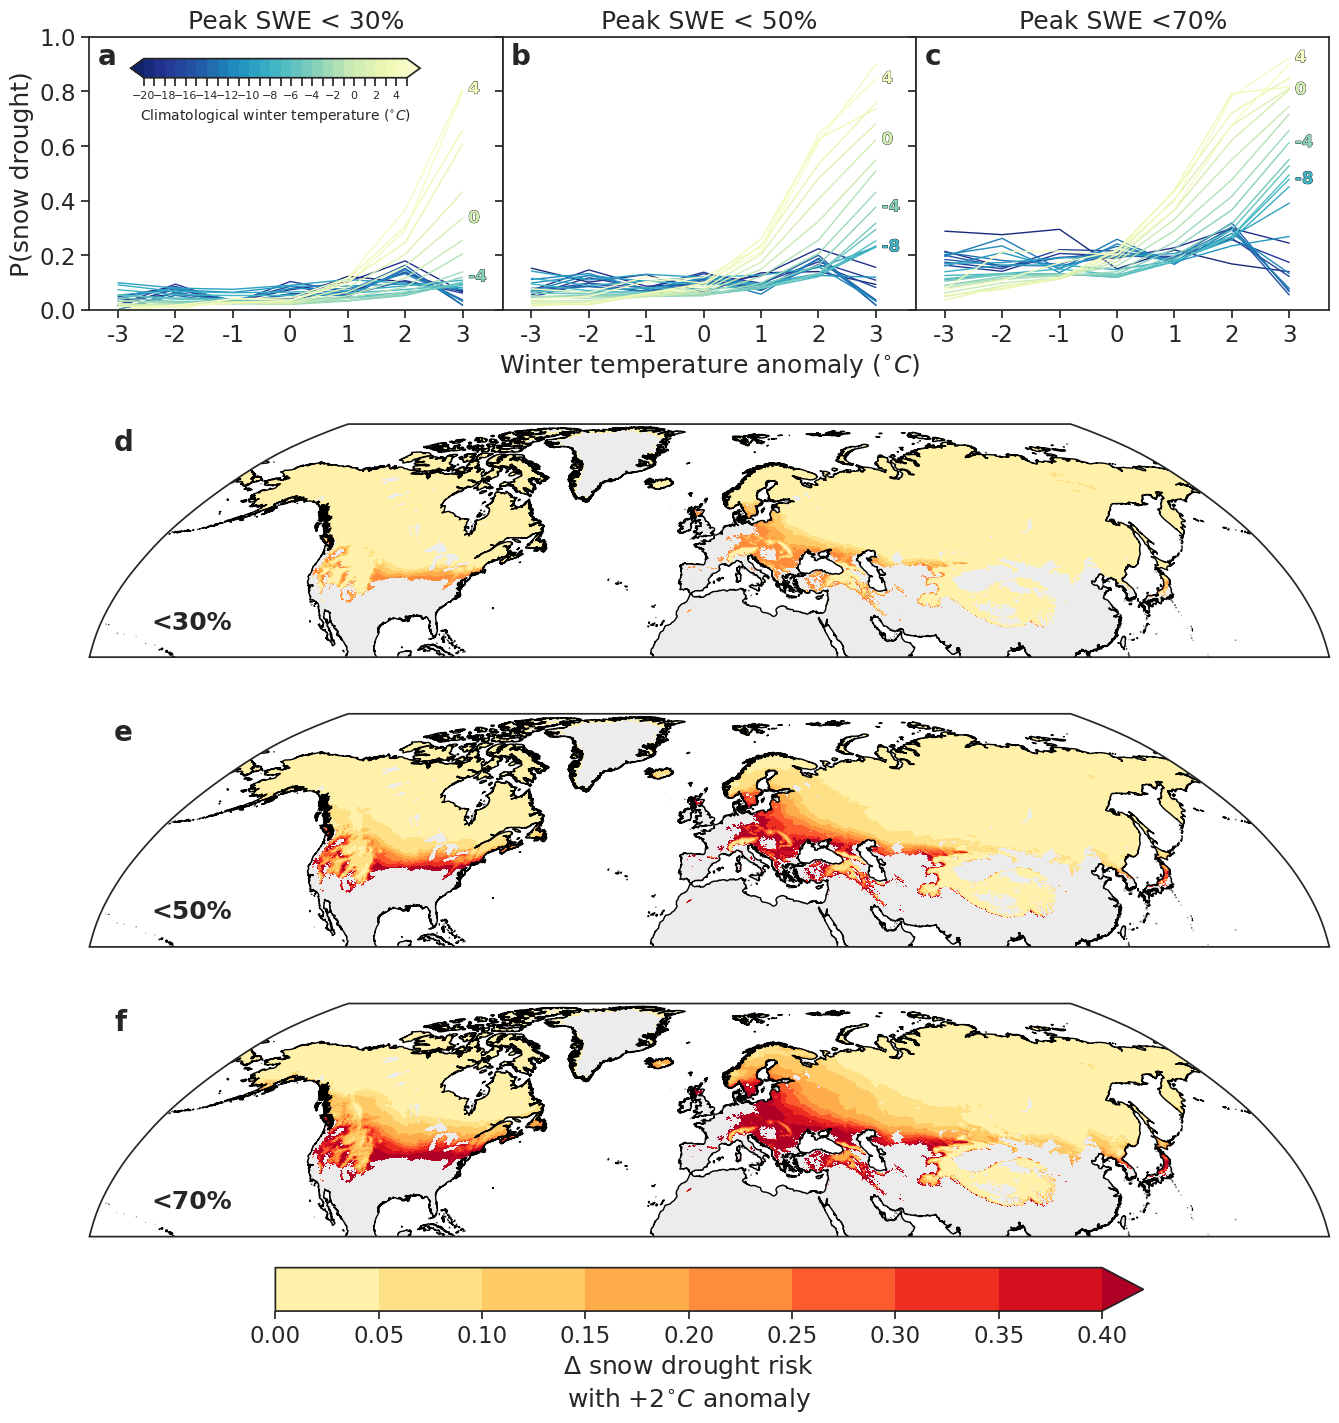

In [54]:
sns.set(style='ticks',font_scale=1.5)
fig=plt.figure(figsize=(16,18))
gs = gridspec.GridSpec(nrows=5,ncols=3,width_ratios=[1,1,1],height_ratios=[1,0.1,1.2,1.2,1.2],hspace=0.1,wspace=0,figure=fig)
ax1 = plt.subplot(gs[0,0])
sd30_comp.plot(ax=ax1,cmap=t_cmap,lw=1,legend=False)
for t in hl_cols[1:]:
    ax1.text(6.1,sd30_comp.loc[3][t],f'{t}',ha='left',va='center',fontsize=12,color=t_cmap(t_norm(t)),fontweight='bold',path_effects=[pe.withStroke(linewidth=0.5,foreground='black')])
ax1.set_xlim(-0.5,6.7)
ax1.set_ylim(0,1)
ax1.set_xlabel("")
ax1.set_ylabel("P(snow drought)")
ax1.set_xticks(range(len(sd30_comp)))
ax1.set_xticklabels(np.arange(-3,4))
ax1.text(0.02,0.98,'a',ha='left',va='top',fontweight='bold',fontsize=20,transform=ax1.transAxes)
ax1.title.set_text("Peak SWE < 30%")

ax2 = plt.subplot(gs[0,1],sharey=ax1)
sd50_comp.plot(ax=ax2,cmap=t_cmap,lw=1,legend=False)
for t in hl_cols:
    ax2.text(6.1,sd50_comp.loc[3][t],f'{t}',ha='left',va='center',fontsize=12,color=t_cmap(t_norm(t)),fontweight='bold',path_effects=[pe.withStroke(linewidth=0.5,foreground='black')])
ax2.set_xlim(-0.5,6.7)
ax2.set_xticks(range(len(sd30_comp)))
ax2.set_xticklabels(np.arange(-3,4))
ax2.set_ylim(0,1)
ax2.set_xlabel("Winter temperature anomaly ($^{\circ}C$)")
ax2.set_ylabel("")
ax2.text(0.02,0.98,'b',ha='left',va='top',fontweight='bold',fontsize=20,transform=ax2.transAxes)
ax2.title.set_text("Peak SWE < 50%")

ax3 = plt.subplot(gs[0,2],sharey=ax1)
sd70_comp.plot(ax=ax3,cmap=t_cmap,lw=1,legend=False)
for t in hl_cols:
    ax3.text(6.1,sd70_comp.loc[3][t],f'{t}',ha='left',va='center',fontsize=12,color=t_cmap(t_norm(t)),fontweight='bold',path_effects=[pe.withStroke(linewidth=0.5,foreground='black')])
ax3.set_xlim(-0.5,6.7)
ax3.set_xticks(range(len(sd30_comp)))
ax3.set_xticklabels(np.arange(-3,4))
ax3.set_ylim(0,1)
ax3.set_xlabel("")
ax3.set_ylabel("")
ax3.text(0.02,0.98,'c',ha='left',va='top',fontweight='bold',fontsize=20,transform=ax3.transAxes)
ax3.title.set_text("Peak SWE <70%")

ax4 = plt.subplot(gs[2,:],projection=ccrs.Robinson())
sd30_risk_plus2.plot(ax=ax4,transform=ccrs.PlateCarree(),cmap=sd_cmap,norm=sd_norm,add_colorbar=False)
ax4.text(0.05,0.15,'<30%',ha='left',va='center',transform=ax4.transAxes,fontweight='bold')

ax5 = plt.subplot(gs[3,:],projection=ccrs.Robinson())
sd50_risk_plus2.plot(ax=ax5,transform=ccrs.PlateCarree(),cmap=sd_cmap,norm=sd_norm,add_colorbar=False)
ax5.text(0.05,0.15,'<50%',ha='left',va='center',transform=ax5.transAxes,fontweight='bold')

ax6 = plt.subplot(gs[4,:],projection=ccrs.Robinson())
sd70_risk_plus2.plot(ax=ax6,transform=ccrs.PlateCarree(),cmap=sd_cmap,norm=sd_norm,add_colorbar=False)
ax6.text(0.05,0.15,'<70%',ha='left',va='center',transform=ax6.transAxes,fontweight='bold')

# ax7 = plt.subplot(gs[2,0],projection=ccrs.Robinson())
# sd30_risk_plus2.plot(ax=ax7,transform=ccrs.PlateCarree(),cmap=sd_cmap,norm=sd_norm,add_colorbar=False)
# ax7.text(-0.1,0.5,'$+2^{\circ}C$',ha='left',va='center',rotation=90,transform=ax7.transAxes)

# ax8 = plt.subplot(gs[2,1],projection=ccrs.Robinson())
# sd50_risk_plus2.plot(ax=ax8,transform=ccrs.PlateCarree(),cmap=sd_cmap,norm=sd_norm,add_colorbar=False)

# ax9 = plt.subplot(gs[2,2],projection=ccrs.Robinson())
# sd70_risk_plus2.plot(ax=ax9,transform=ccrs.PlateCarree(),cmap=sd_cmap,norm=sd_norm,add_colorbar=False)

labels = ['d','e','f']
for i,ax in enumerate([ax4,ax5,ax6]):
    ax.coastlines('10m')
    ax.add_feature(cartopy.feature.LAND,color='grey',alpha=0.15)
    ax.set_extent([-180,180,20,85],ccrs.PlateCarree())
    ax.text(0.02,0.98,labels[i],ha='left',va='top',fontweight='bold',fontsize=20,transform=ax.transAxes)
    # ax3.title.set_text("+1$^{\circ}C$")

tcax = ax1.inset_axes([0.1,0.85,0.70,0.07])
t_sm = plt.cm.ScalarMappable(norm=t_norm,cmap=t_cmap)
t_sm.set_array([])
t_cbar = fig.colorbar(t_sm,cax=tcax,orientation='horizontal',drawedges=False,ticks=np.arange(-20,6,1),extend='both',pad=0.03,shrink=0.9)
t_cbar.ax.set_xlabel(r"Climatological winter temperature ($^{\circ}C$)",fontsize=10)
t_cbar.ax.tick_params(labelsize=8)
for l in t_cbar.ax.get_xticklabels()[1::2]:
    l.set_visible(False)
# for l in t_cbar.ax.get_xticklabels()[4:-1:2]:
#     l.set_fontweight("bold")
sd_sm = plt.cm.ScalarMappable(norm=sd_norm,cmap=sd_cmap)
sd_sm.set_array([])
sd_cbar = fig.colorbar(sd_sm,ax=[ax4,ax5,ax6],orientation='horizontal',drawedges=False,ticks=np.arange(0,0.41,0.05),extend='max',pad=0.03,shrink=0.7)
sd_cbar.ax.set_xlabel(r"$\Delta$ snow drought risk"+"\nwith $+2^{\circ}C$ anomaly",)

plt.savefig(os.path.join(project_dir,'reports','figures','r1','supp_mat','png','snow_drought_thresh.png'),bbox_inches='tight',dpi=350)
plt.savefig(os.path.join(project_dir,'reports','figures','r1','supp_mat','pdf','snow_drought_thresh.pdf'),bbox_inches='tight',dpi=350)
    